## Optimal Q_tau* test

junix --filepath ./Test.ipynb --output_dir ./results/intermediate_curves

In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
status_step = 500
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
taus = [0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.090, 0.080, 0.070, 0.060, 0.050, 0.040, 0.030, 0.020, 0.010]

In [23]:
from gym import Env, spaces
from gym.utils import seeding
from model_functions import * 

taus = np.flip(np.linspace(0, 0.9, num=50))
type(np.ones(7))
type({})
type(spaces.Discrete(nA))

gym.spaces.discrete.Discrete

In [4]:
results = []
iterations = {}
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    
    Q_star_tau, iterations[tau] = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, tmdp.reward, 1e-4, tmdp.gamma)
    
    d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.gamma)
    # Compute the gamma discounted state distribution
    delta = compute_delta(d, get_policy(Q_star_tau))
    # Compute the state value function
    V_star_tau = get_value_function(Q_star_tau) 
    # Compute the expected reward when picking action a in state s
    r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)
    # Compute the state action next-state value function U_tau(s,a,s') = R(s,a) + \gamma*V_tau(s')
    U_star_tau = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V_star_tau)
    # Rebuild Q using U as Q_tau(s,a) = \sum{s' \in S}P_tau(s'|s,a)*U_tau(s,a,s')
    Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U_star_tau)

    # Compute the relative model advantage function hat \hat{A}_{tau, mu}(s,a)
    A_tau_hat = compute_relative_model_advantage_function_hat(tmdp.P_mat, tmdp.xi, U_star_tau)
    # Compute the discounted distribution relative model advantage function hat \hat{A}_{tau, mu}
    A_hat = compute_discounted_distribution_relative_model_advantage_function_hat(A_tau_hat, delta)
    # The dissimilarity term D = D_e * gamma * D_inf is upperbounded by 4*gamma+(tau - tau_1)
    # Compute Delta Q_tau as the superior among the difference of the L_1 norm of elements of Q_tau
    d_q = get_sup_difference_q(Q_star_tau)
    tau_1 = compute_tau_prime(A_hat, tmdp.gamma, tmdp.tau, d_q)
    
    J_star_tau = get_expected_avg_reward(tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    J_0 = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)

    # Compute the performance improvement lower bound when moving to tau=0
    l_b = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, 0.0)
    print("Moving from {} to {}".format(tmdp.tau, 0.))
    print("Theoretical lb on performance improvement: {}, Empirical one: {}".format(l_b, J_0-J_star_tau))
    print("Optimal tau': ", tau_1)
    print("Advantage: ", (tmdp.tau*A_hat))
    print("\n")
    results.append({"Q": Q_star_tau, "tau":tmdp.tau, "J":J_star_tau, "J_0":J_0, "policy":get_policy(Q_star_tau), "l_b":l_b, "Adv":tmdp.tau*A_hat})

Moving from 0.9 to 0.0
Theoretical lb on performance improvement: -9681.3491455737, Empirical one: 142.79622848193597
Optimal tau':  0.901278344194068
Advantage:  -5.469412689521509


Moving from 0.8816326530612246 to 0.0
Theoretical lb on performance improvement: -9556.258173270664, Empirical one: 139.94632939817984
Optimal tau':  0.8828924972785992
Advantage:  -5.431273883884293


Moving from 0.863265306122449 to 0.0
Theoretical lb on performance improvement: -9421.70679444506, Empirical one: 137.13486746110033
Optimal tau':  0.86450617656451
Advantage:  -5.386192044332248


Moving from 0.8448979591836735 to 0.0
Theoretical lb on performance improvement: -9278.059659963707, Empirical one: 134.36074711675678
Optimal tau':  0.8461193637791717
Advantage:  -5.334188612328623


Moving from 0.826530612244898 to 0.0
Theoretical lb on performance improvement: -9125.681575949407, Empirical one: 131.62281204996972
Optimal tau':  0.8277320403261909
Advantage:  -5.2752898109933115


Moving from 

In [5]:
print(iterations)

{0.9: 70, 0.8816326530612246: 71, 0.863265306122449: 71, 0.8448979591836735: 71, 0.826530612244898: 72, 0.8081632653061225: 72, 0.789795918367347: 72, 0.7714285714285715: 73, 0.753061224489796: 73, 0.7346938775510204: 74, 0.7163265306122449: 74, 0.6979591836734694: 74, 0.6795918367346939: 75, 0.6612244897959184: 75, 0.6428571428571429: 76, 0.6244897959183674: 76, 0.6061224489795919: 76, 0.5877551020408164: 77, 0.5693877551020409: 77, 0.5510204081632654: 78, 0.5326530612244899: 79, 0.5142857142857143: 79, 0.49591836734693884: 80, 0.47755102040816333: 81, 0.4591836734693878: 81, 0.4408163265306123: 82, 0.42244897959183675: 85, 0.40408163265306124: 86, 0.38571428571428573: 88, 0.3673469387755102: 89, 0.3489795918367347: 90, 0.3306122448979592: 91, 0.3122448979591837: 92, 0.2938775510204082: 93, 0.2755102040816327: 94, 0.2571428571428572: 95, 0.23877551020408166: 97, 0.22040816326530616: 98, 0.20204081632653062: 99, 0.1836734693877551: 101, 0.1653061224489796: 102, 0.1469387755102041: 105,

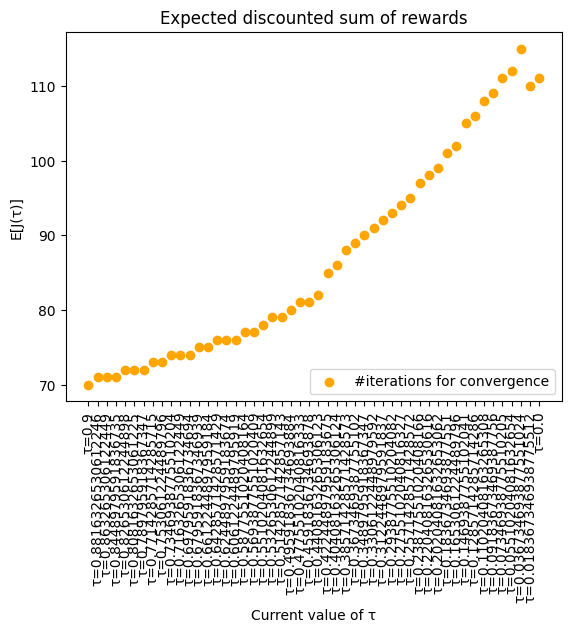

In [6]:
x = np.array([])
y = np.array([])
z = np.array([])
for tau in taus:
    y = np.append(y, iterations[tau])
    label = "τ="+str(tau)
    x = np.append(x, label)
x_map = np.array([i for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(x, y, c='orange', label='#iterations for convergence')
plt.xticks(x_map, x)

plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")

plt.legend(loc="lower right")



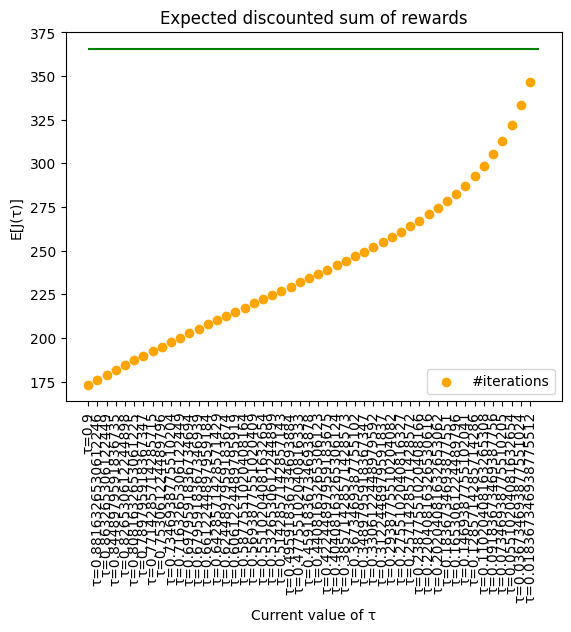

In [7]:
x = np.array([])
y = np.array([])
k = np.array([])
for i, res in enumerate(results):
    if i < len(results)-1:
        y = np.append(y, res['J'])
        label = "τ="+str(res['tau'])
        x = np.append(x, label)
x_map = np.array([i for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(x, y, c='orange', label='#iterations')
plt.xticks(x_map, x)

plt.hlines(y=results[-1]['J_0'], xmin=0, xmax=len(x), colors='g')
plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")

plt.legend(loc="lower right")




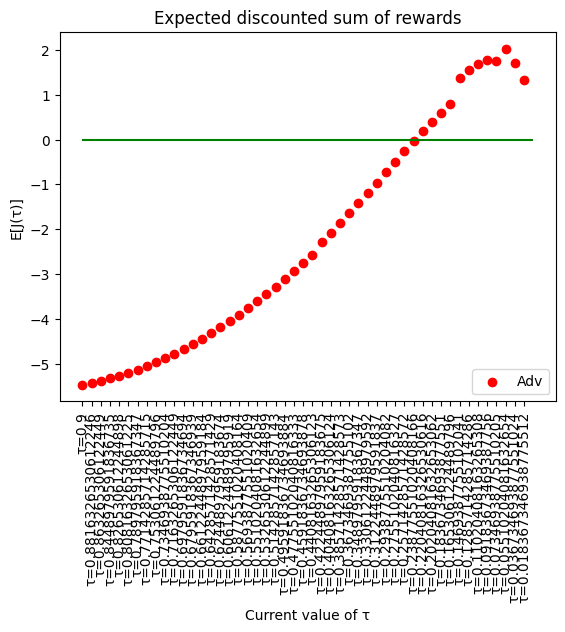

In [8]:
x = np.array([])
y = np.array([])
z = np.array([])
k = np.array([])
old = -np.inf
for i, res in enumerate(results):
    if i < len(results)-1:
        y = np.append(y, res['J'])
        label = "τ="+str(res['tau'])
        x = np.append(x, label)
        z = np.append(z, res['J_0'])
        k = np.append(k, res['Adv'])
        if res['Adv'] > 0 and old < 0:
            t_lim = res['tau']
            old = np.inf
x_map = np.array([i for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
#plt.scatter(x, y, c='orange', label='J on current τ')
#plt.scatter(x, z, label='J on original problem')
plt.scatter(x, k, label='Adv', c='r')
plt.xticks(x_map, x)

plt.hlines(y=0, xmin=0, xmax=len(x), colors='g')
plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")

plt.legend(loc="lower right")


In [9]:
print("The limit value of tau is:", t_lim)

The limit value of tau is: 0.22040816326530616


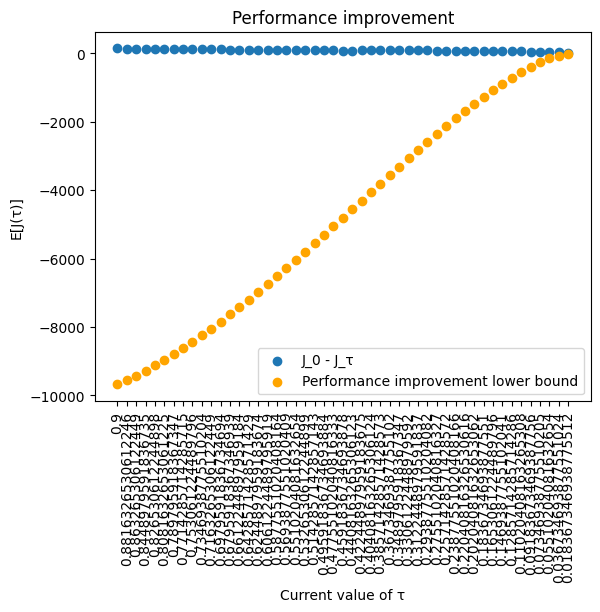

In [10]:
x = np.array([])
y = np.array([])
z = np.array([])
for i, res in enumerate(results):
    if i < len(results)-1:
        y = np.append(y, res['J_0'] - res['J'])
        label = str(res['tau'])
        x = np.append(x, label)
        z = np.append(z, res['l_b'])
x_map = np.array([i for i in range(len(x))])

plt.scatter(x, y, label='J_0 - J_τ')
plt.scatter(x, z,  c='orange', label='Performance improvement lower bound')
plt.xticks(x_map, x)

plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Performance improvement")

plt.legend(loc="lower right")


In [11]:
"""# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    
    Q_star_tau = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, tmdp.reward, 1e-4, tmdp.gamma)

    d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.gamma)
    # Compute the gamma discounted state distribution
    delta = compute_delta(d, get_policy(Q_star_tau))
    # Compute the state value function
    V_star_tau = get_value_function(Q_star_tau) 
    # Compute the expected reward when picking action a in state s
    r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)
    # Compute the state action next-state value function U_tau(s,a,s') = R(s,a) + \gamma*V_tau(s')
    U_star_tau = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V_star_tau)
    # Rebuild Q using U as Q_tau(s,a) = \sum{s' \in S}P_tau(s'|s,a)*U_tau(s,a,s')
    Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U_star_tau)


    # Compute the relative model advantage function hat \hat{A}_{tau, mu}(s,a)
    A_tau_hat = compute_relative_model_advantage_function_hat(tmdp.P_mat, tmdp.xi, U_star_tau)
    # Compute the discounted distribution relative model advantage function hat \hat{A}_{tau, mu}
    A_hat = compute_discounted_distribution_relative_model_advantage_function_hat(A_tau_hat, delta)
    # The dissimilarity term D = D_e * gamma * D_inf is upperbounded by 4*gamma+(tau - tau_1)
    # Compute Delta Q_tau as the superior among the difference of the L_1 norm of elements of Q_tau
    d_q = get_sup_difference_q(Q_star_tau)
    
    # Compute the performance improvement lower bound when moving to tau=0
    l_b = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, 0.0)
    
    
    tau_1 = compute_tau_prime(A_hat, tmdp.gamma, tmdp.tau, d_q)
    tmdp_1 = tmdp = TMDP(river, xi, tau_1, gamma)
    print(tmdp.tau)
   
    print(tmdp_1.tau)
    print(tmdp.tau - A_hat*(1-gamma)/(4*gamma**2*d_q))

    J_star_tau = get_expected_avg_reward(tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    J_0 = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    J_1 = get_expected_avg_reward(tmdp_1.P_mat_tau, get_policy(Q_star_tau), tmdp_1.reward, tmdp_1.gamma, tmdp_1.mu)

    print(tmdp.tau)
   

    print("Moving from {} to {}".format(tmdp.tau, 0.))
    print("Theoretical lb on performance improvement: {}, Empirical one: {}\n".format(l_b, J_0-J_star_tau))

    print("Moving from {} to {}".format(tmdp.tau, tmdp_1.tau))
    l_b_1 = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, tau_1)
    opt_lb = compute_optimal_lower_bound(A_hat, gamma, d_q)
    print("Theoretical lb on performance improvement: {}, Empirical one: {}".format(l_b_1, J_1-J_star_tau))
    print("\nThe lower bound for tau' is: {}".format(opt_lb))
    print("\n\n")
    
    results.append({"Q": Q_star_tau, "tau":tmdp.tau, "J":J_star_tau, "J_0":J_0, "policy":get_policy(Q_star_tau), "l_b":l_b})"""

'# Learning from scratch with different values of tau\nfor tau in taus:\n    tmdp = TMDP(river, xi, tau, gamma)\n    \n    Q_star_tau = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, tmdp.reward, 1e-4, tmdp.gamma)\n\n    d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.gamma)\n    # Compute the gamma discounted state distribution\n    delta = compute_delta(d, get_policy(Q_star_tau))\n    # Compute the state value function\n    V_star_tau = get_value_function(Q_star_tau) \n    # Compute the expected reward when picking action a in state s\n    r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)\n    # Compute the state action next-state value function U_tau(s,a,s\') = R(s,a) + \\gamma*V_tau(s\')\n    U_star_tau = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V_star_tau)\n    # Rebuild Q using U as Q_tau(s,a) = \\sum{s\' \\in S}P_tau(s\'|s,a)*U_tau(s,a,s\')\n    Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U_star_tau)\n\n\n    # Compute

In [12]:
results = []
bad = []
iterations = {}
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    
    Q_star_tau, iterations[tau] = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, tmdp.reward, 1e-4, tmdp.gamma)

    d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.gamma)
    # Compute the gamma discounted state distribution
    delta = compute_delta(d, get_policy(Q_star_tau))
    # Compute the state value function
    V_star_tau = get_value_function(Q_star_tau) 
    # Compute the expected reward when picking action a in state s
    r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)
    # Compute the state action next-state value function U_tau(s,a,s') = R(s,a) + \gamma*V_tau(s')
    U_star_tau = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V_star_tau)
    # Rebuild Q using U as Q_tau(s,a) = \sum{s' \in S}P_tau(s'|s,a)*U_tau(s,a,s')
    Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U_star_tau)


    # Compute the relative model advantage function hat \hat{A}_{tau, mu}(s,a)
    A_tau_hat = compute_relative_model_advantage_function_hat(tmdp.P_mat, tmdp.xi, U_star_tau)
    # Compute the discounted distribution relative model advantage function hat \hat{A}_{tau, mu}
    A_hat = compute_discounted_distribution_relative_model_advantage_function_hat(A_tau_hat, delta)
    # The dissimilarity term D = D_e * gamma * D_inf is upperbounded by 4*gamma+(tau - tau_1)
    # Compute Delta Q_tau as the superior among the difference of the L_1 norm of elements of Q_tau
    d_q = get_sup_difference_q(Q_star_tau)
    
    J_star_tau = get_expected_avg_reward(tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    print("evaluating for tau: {}".format(tmdp.tau))
    for t in taus:
        if(t < tau):
            tmdp_1 = TMDP(river, xi, t, gamma)
            J_1 = get_expected_avg_reward(tmdp_1.P_mat_tau , get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)

            # Compute the performance improvement lower bound when moving to tau=0
            l_b = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, tmdp_1.tau)
            print("Moving from {} to {}".format(tmdp.tau, tmdp_1.tau))
            print("Theoretical lb on performance improvement: {}, Empirical one: {}\n".format(l_b, J_1-J_star_tau))
            if J_1-J_star_tau < l_b:
                bad.append({'tau':tmdp.tau, 'tau_1':tmdp_1.tau, "J_star":J_star_tau, "J_1":J_1})
    print("\n")
    results.append({"Q": Q_star_tau, "tau":tmdp.tau, "J":J_star_tau, "J_0":J_0, "policy":get_policy(Q_star_tau), "l_b":l_b})

evaluating for tau: 0.9
Moving from 0.9 to 0.8816326530612246
Theoretical lb on performance improvement: -5.125642330922069, Empirical one: 2.849899083756128

Moving from 0.9 to 0.863265306122449
Theoretical lb on performance improvement: -18.270155981026655, Empirical one: 5.661361020835642

Moving from 0.9 to 0.8448979591836735
Theoretical lb on performance improvement: -39.4335409503136, Empirical one: 8.435481365179186

Moving from 0.9 to 0.826530612244898
Theoretical lb on performance improvement: -68.61579723878295, Empirical one: 11.173416431966245

Moving from 0.9 to 0.8081632653061225
Theoretical lb on performance improvement: -105.8169248464347, Empirical one: 13.876387201794586

Moving from 0.9 to 0.789795918367347
Theoretical lb on performance improvement: -151.03692377326885, Empirical one: 16.545683557213124

Moving from 0.9 to 0.7714285714285715
Theoretical lb on performance improvement: -204.27579401928546, Empirical one: 19.182668883362908

Moving from 0.9 to 0.7530612

In [13]:
print(bad)

[]
